# Emotion Recognition from Speech Machine learning & Deep Learning

**Model: CNN-based Emotion Recognition**
* Emotions: Neutral, Disgust, Happy, Sad, Fear, Angry, Surprise

In [1]:
import os
os.chdir('/kaggle/working/')

In [2]:
!ls

**Import libraries**

In [3]:
import os
import sys
import keras
import librosa
import timeit
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import librosa.display
import tensorflow.keras.layers as L
from joblib import Parallel, delayed
import IPython.display as ipd
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

2024-03-15 03:43:49.647913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 03:43:49.648026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 03:43:49.773689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Done


**Update package information and install libsndfile1 for audio processing.**

In [4]:
!apt-get update
!apt-get install -y libsndfile1
!pip install --upgrade librosa
!pip show librosa

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1426 kB]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:4 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:6 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]       
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:8 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:9 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [19.5 kB]
Get:10 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [617 kB]
Hit:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease              
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd6

**Load dataset**

In [5]:
ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
# print(ravdess_directory_list)
Crema = "/kaggle/input/cremad/AudioWAV/"
Crema_directory_list = os.listdir(Crema)
# print(Crema_directory_list)
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"
Tess_directory_list = os.listdir(Tess)
# print(Tess_directory_list)
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
Savee_directory_list = os.listdir(Savee)
# print(Savee_directory_list)

# **Data Preprocessing**

**Ravdees**

In [6]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    # print(actor)
    for f in actor:
        # print(f)
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [7]:
# Print the first element of the 'actor' list
print(actor[0])

# Print the first element of the 'part' list
print(part[0])

# Print the first element of the 'file_path' list
print(file_path[0])

# Convert the third element of the 'part' list to an integer and print it
print(int(part[2]))

# Print the value stored in the variable 'f'
print(f)

03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
5
03-01-05-02-01-02-07.wav


In [8]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

**CREMA-D**
* 7,442 video clips
* 91 actors (48 males, 43 females)
* Ages 20 to 74, diverse racial/ethnic backgrounds
* 12 sentences expressing 6 emotions (Anger, Disgust, Fear, Happy, Neutral, Sad)
* Emotion levels: Low, Medium, High, Unspecified
* Valuable for emotion recognition research, offers insights into cross-cultural and age-related differences.

In [9]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


**TESS**
* Two actresses, aged 26 and 64.
* They spoke 200 target words in the phrase "Say the word _".
* Emotions expressed:
   * Anger
   * Disgust
   * Fear
   * Happiness
   * Pleasant Surprise
   * Sadness
   * Neutral
* Recordings made for each emotion.
* Total of 2800 audio files in WAV format.
* Dataset organized by actress, with separate folders for each emotion.
* Within emotion folders, audio files for all 200 target words.

In [10]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


**SAVEE**
* SAVEE database recorded by four English-speaking men:
  * DC
  * JE
  * JK
  * KL.
* All speakers were postgraduate students and researchers at the University of Surrey, aged 27 to 31.
* Emotions categorized as,
  * Anger
  * Disgust
  * Fear
  * Happiness
  * Sadness
  * Surprise
  * Neutral.
* Neutral included to ensure recordings for all 7 emotion categories.
* Text material comprised 15 TIMIT sentences for each emotion.
* Each emotion had 3 common, 2 emotion-specific, and 10 generic sentences.
* Total of 120 utterances per speaker, covering various emotions and neutral expressions.

In [11]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
fear         60
happy        60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64


**Combine 4 Datasets**

In [12]:
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("/kaggle/working/data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [13]:
print(data_path.Emotions.value_counts())

Emotions
disgust     1923
sad         1923
fear        1923
happy       1923
angry       1923
neutral     1895
surprise     652
Name: count, dtype: int64


**EDA**

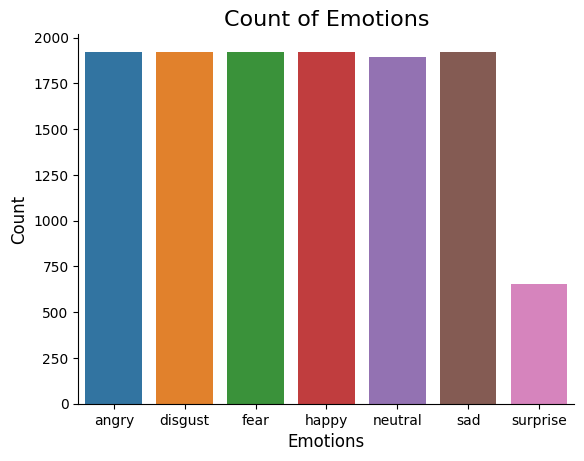

In [14]:
data_path['Emotions'] = data_path['Emotions'].astype('category')
plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [15]:
data,sr = librosa.load(file_path[0])
print("sr",sr)
print(ipd.Audio(data,rate=sr))

sr 22050
<IPython.lib.display.Audio object>


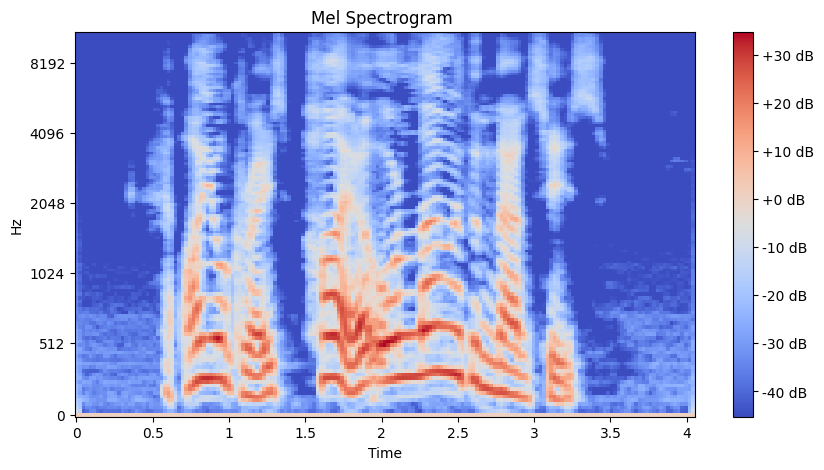

In [16]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

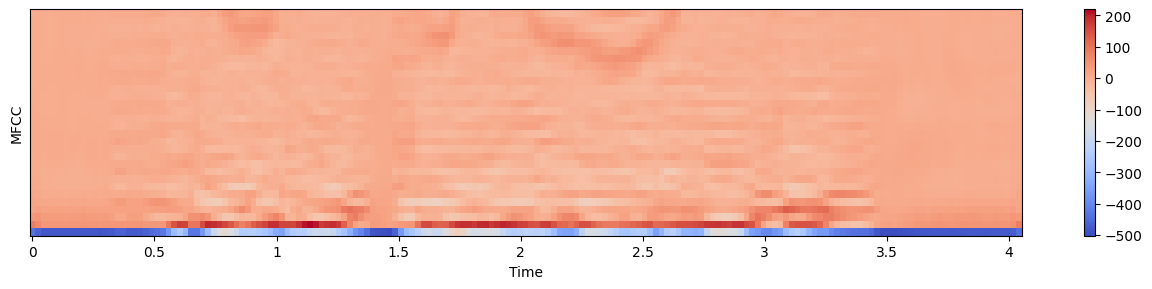

In [17]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)
# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
ipd.Audio(data,rate=sr)

**Data augmentation**

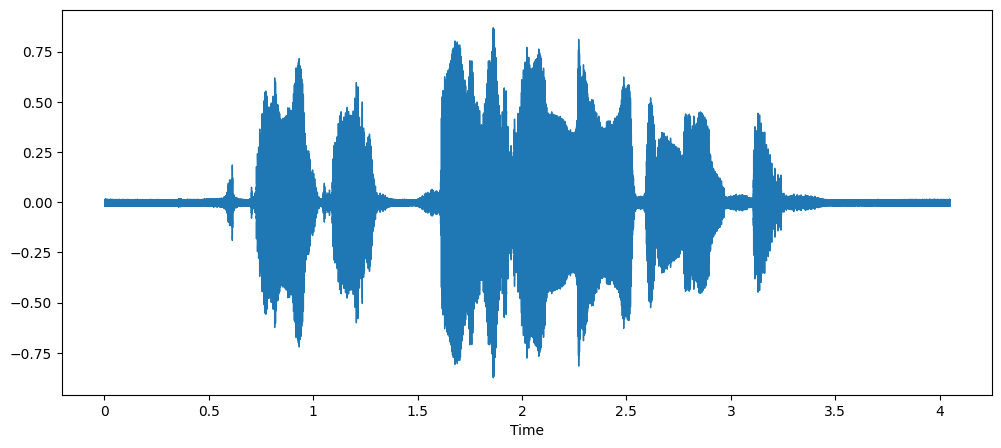

In [18]:
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

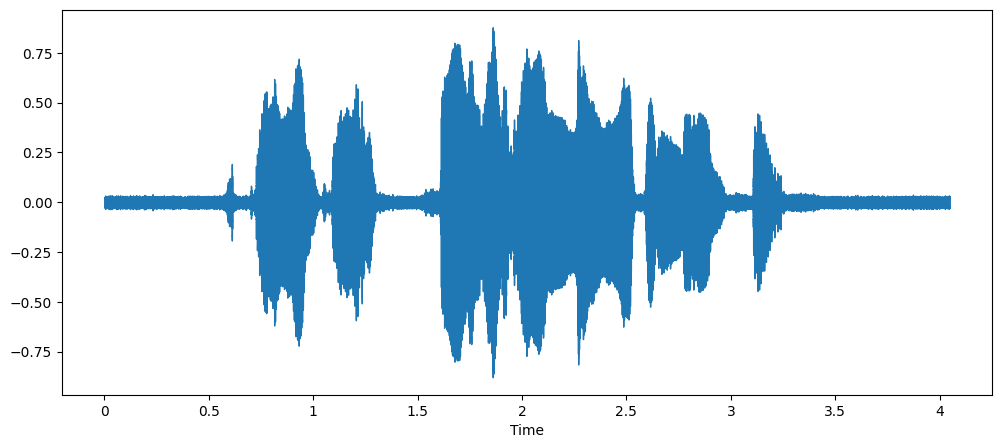

In [19]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

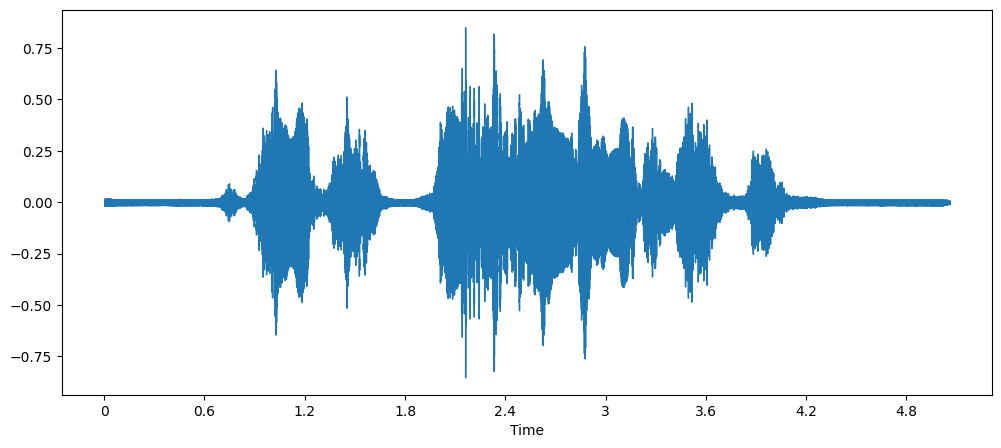

In [20]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)


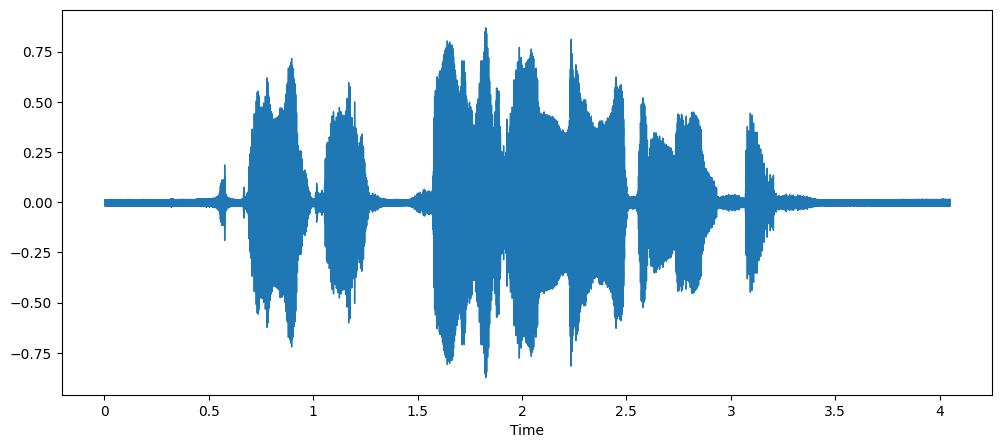

In [21]:
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

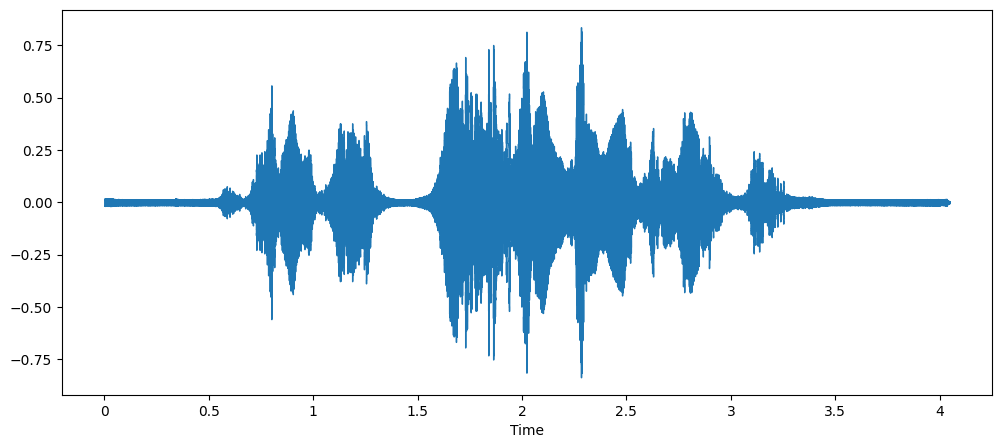

In [22]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

**Feature extraction**

In [23]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


# **Extract Features**

In [24]:
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
#     print("extract features")
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        my_mfcc(data, sr=sr, n_fft=frame_length, hop_length=hop_length)
                        ))
#     print("extract features end")
    return result

def my_mfcc(data, sr, n_fft=2048, hop_length=512, flatten: bool = True):
#     print("mfcc")
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
#     print("mfcc r")
    return np.squeeze(mfcc_result.T) if not flatten else np.ravel(mfcc_result.T)


**Extract Features Normally**

In [25]:
# start = timeit.default_timer()
# X, Y = [], []
# for index, (path, emotion) in tqdm(enumerate(zip(data_path.Path, data_path.Emotions))):
#     features = get_features(path)
#     for i in features:
#         X.append(i)
#         Y.append(emotion)
#     if index % 500 == 0:
#         tqdm.write(f'{index} audio has been processed')
# print('Done')
# stop = timeit.default_timer()
# print('Time: ', stop - start)

**Faster way**

In [26]:
start = timeit.default_timer()
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    i=0
    for ele in features:
#         print(i)
        X.append(ele)
        Y.append(emotion)
#         print("h")
        i=i+1
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

X = []
Y = []
for result in results:
    x, y = result
#     print("hello")
    X.extend(x)
#     print("x")
    Y.extend(y)
#     print("y")

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  616.7593405929999


In [27]:
len(X), len(Y), data_path.Path.shape

(48648, 48648, (12162,))

**Save features to dataframe and preprocess**

In [28]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.226562,0.358398,0.453613,0.416016,0.371582,0.301758,0.268066,0.253418,0.248535,0.249023,...,-1.593677,-1.775230,-1.536379,-1.015354,-0.376623,0.255360,0.835873,1.390643,1.965337,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518303,0.838663,1.308733,1.855111,2.405192,2.896439,3.283493,3.541682,3.667480,surprise
3,0.266113,0.394531,0.526367,0.527344,0.519531,0.514648,0.509766,0.495605,0.486816,0.493164,...,-0.070287,5.888906,3.837884,2.425986,1.151576,0.693512,-1.516673,0.005534,-1.835281,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral


In [29]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [30]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [31]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

**Prepare Data**

In [32]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [33]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [34]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [35]:
#split data to train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [36]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [37]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

**model parameters**

In [38]:
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [39]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# **CNN Model**

In [40]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [41]:
model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (Batch  (None, 2376, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 512)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 1188, 512)         2048      
 chNormalization)                                                
                                                        

In [43]:
history=model.fit(x_traincnn, y_train, epochs=30, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/30
609/609 [==============================] - 104s 171ms/step - loss: 0.0472 - accuracy: 0.9841 - val_loss: 0.2619 - val_accuracy: 0.9249 - lr: 0.0010
Epoch 2/30
609/609 [==============================] - 104s 171ms/step - loss: 0.0730 - accuracy: 0.9770 - val_loss: 0.2021 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 3/30
609/609 [==============================] - 104s 171ms/step - loss: 0.1206 - accuracy: 0.9610 - val_loss: 0.1379 - val_accuracy: 0.9598 - lr: 0.0010
Epoch 4/30
609/609 [==============================] - 104s 171ms/step - loss: 0.0302 - accuracy: 0.9905 - val_loss: 0.1285 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 5/30
609/609 [==============================] - 104s 171ms/step - loss: 0.0331 - accuracy: 0.9896 - val_loss: 0.1430 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 6/30
609/609 [==============================] - 104s 171ms/step - loss: 0.0623 - accuracy: 0.9792 - val_loss: 0.1419 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 7/30
609/609 [==========================

**save model weights**

In [47]:
model_save_path = '/kaggle/working/speech_cnn_new_model.h5'
model.save(model_save_path)
print("Model saved successfully at:", model_save_path)

Model saved successfully at: /kaggle/working/speech_cnn_new_model.h5


In [48]:
%cd /kaggle/working

/kaggle/working


In [54]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/best_model1_weights.h5 (deflated 7%)
  adding: kaggle/working/emotion.csv (deflated 54%)
  adding: kaggle/working/data_path.csv (deflated 94%)
  adding: kaggle/working/speech_cnn_new_model.h5 (deflated 7%)


In [55]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

**check prediction on test data**

In [56]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 [==============================] - 8s 21ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
5,happy,happy
6,happy,happy
7,fear,fear
8,fear,fear
9,surprise,surprise


**model evaluation**

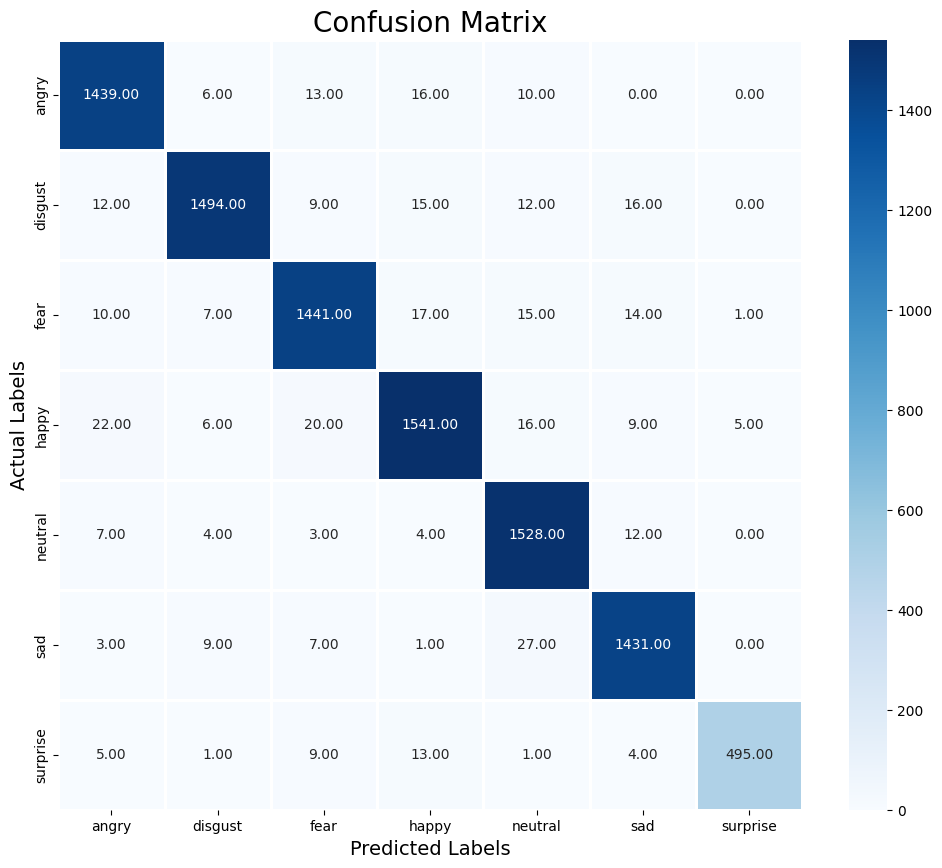

              precision    recall  f1-score   support

       angry       0.96      0.97      0.97      1484
     disgust       0.98      0.96      0.97      1558
        fear       0.96      0.96      0.96      1505
       happy       0.96      0.95      0.96      1619
     neutral       0.95      0.98      0.96      1558
         sad       0.96      0.97      0.97      1478
    surprise       0.99      0.94      0.96       528

    accuracy                           0.96      9730
   macro avg       0.97      0.96      0.96      9730
weighted avg       0.96      0.96      0.96      9730



In [57]:
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))